# Peak fitting using damped harmonic oscillator model
This tutorial demonstrates how one can analyze the current correlations and dynamic structure factor by fitting peaks to analytical expressions for a damped harmonic oscillators (DHO).

## Damped harmonic oscillator
The details of the DHO model can be found in the [theoretical background](https://dynasor.materialsmodeling.org/theory.html#damped-harmonic-oscillator-model). In short, the position autocorrelation function of a DHO is given by
\begin{equation*}
F(t) = A \mathrm{e}^{- t/\tau} \left ( \cos{ \omega_e t} + \frac{1}{\tau\omega_e}\sin{ \omega_e t}\right ),
\end{equation*}
where $\omega_e = \sqrt{\omega_0^2 - 1/\tau^2}$ is the angular eigenfrequency of the DHO. The Fourier transform of the above is 
\begin{equation*}
S(\omega) = A\frac{2\Gamma \omega_0^2}{(\omega^2 - \omega_0^2)^2 + (\Gamma\omega)^2},
\end{equation*}
where $\omega_0$ is the natural angular frequency, $\Gamma$ the damping (lifetime $\tau=2/\Gamma$) and $A$ an arbitrary amplitude of the DHO.

Note that for current correlations (and their respective Fourier transforms) one must use the velocity autocorrelation function for the DHO, whereas for the intermediate scattering function (and dynamic structure factor) the position autocorrelation function is used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dynasor import read_sample_from_npz
from dynasor.units import radians_per_fs_to_meV
from scipy.optimize import curve_fit

## Al FCC
First, we will look at the current correlations, $C_\text{L}(\boldsymbol{q}, t)$ and $C_\text{T}(\boldsymbol{q}, t)$, in Al FCC at a temperature of T = 900 K and fit these with DHO models.

The full dispersion from current correlations is shown below, where blue corresponds to longitudinal modes and red to transverse modes.

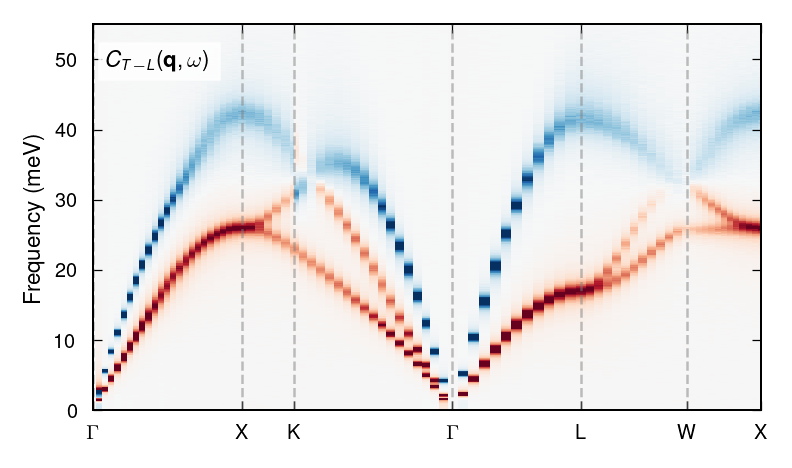


Here, we will only consider fitting the current correlations for one q-point, namely $\boldsymbol{q}=[0.5, 0.5, 0.0]$ which sits between K and $\Gamma$.

This data is stored as a pandas dataframe in a csv file, obtained via `sample.to_dataframe(q_index)` ([see here](https://dynasor.materialsmodeling.org/interface_python/sample.html#dynasor.sample.DynamicSample.to_dataframe)), and can be read using pandas.

In [2]:
# read data
alat = 4.05
df = pd.read_csv('Al_fcc_size24_T900_qindex38.csv')
print(df)

w = df.omega
t = df.time
Clqt = df.Clqt
Ctqt = df.Ctqt
Clqw = df.Clqw
Ctqw = df.Ctqw

         omega     time       Clqt   Clqt_X_X      Clqw  Clqw_X_X       Ctqt  \
0     0.000000      0.0  27.747023  27.747023  2.632250  2.632250  27.804061   
1     0.000157      5.0  26.699390  26.699390  3.549897  3.549897  27.373739   
2     0.000314     10.0  23.540678  23.540678  2.247025  2.247025  26.121036   
3     0.000471     15.0  18.562543  18.562543  3.889430  3.889430  24.101959   
4     0.000628     20.0  12.212002  12.212002  3.864050  3.864050  21.406585   
...        ...      ...        ...        ...       ...       ...        ...   
7996  1.256009  39980.0  -0.075647  -0.075647 -0.014731 -0.014731   0.051283   
7997  1.256166  39985.0  -0.062453  -0.062453 -0.012500 -0.012500   0.070549   
7998  1.256323  39990.0  -0.045894  -0.045894 -0.011104 -0.011104   0.086015   
7999  1.256480  39995.0  -0.024718  -0.024718 -0.004054 -0.004054   0.097392   
8000  1.256637  40000.0   0.001406   0.001406 -0.002088 -0.002088   0.105129   

       Ctqt_X_X       Ctqw   Ctqw_X_X  

First, we fit the data to a DHO in the time domain, although it could just as well be done in the frequency domain.
The fitting can be accomplished in many ways, but here we simply use a least-square fit via SciPy's `curve_fit` function.
It is important to select some reasonable starting parameters in order to make the fit converge to a good solution. Note that while the fit is carried out in time domain, the resulting fit parameters ($\omega_0, \Gamma, A$) can directly be used in the frequency domain too.

In [3]:
from dynasor.tools.damped_harmonic_oscillator import acf_velocity_dho, psd_velocity_dho


# fitting longitudinal, in time domain
p0 = [30/radians_per_fs_to_meV, 2/radians_per_fs_to_meV, 1e4]  # initial guesses for parameters w0, Gamma, A
params_L, _ = curve_fit(acf_velocity_dho, t, Clqt, p0)

w0_L = params_L[0] * radians_per_fs_to_meV
gamma_L = params_L[1] * radians_per_fs_to_meV
print(f' Fitting results for C_L(q, t): w0 {w0_L:.2f} meV, gamma {gamma_L:.2f} meV')

# generate resulting dho data, in both time and frequency domain
t_lin = np.linspace(0, t.max(), 100000)
w_lin = np.linspace(0, w.max(), 100000)

Clqt_fit = acf_velocity_dho(t_lin, *params_L)
Clqw_fit = psd_velocity_dho(w_lin, *params_L)

 Fitting results for C_L(q, t): w0 35.00 meV, gamma 4.13 meV


Next, for fitting the tranvserse current correlation we need to employ a sum of two DHOs.

In [4]:
def two_acfs(t, w01, gamma1, A1, w02, gamma2, A2):
    acf1 = acf_velocity_dho(t, w01, gamma1, A1)
    acf2 = acf_velocity_dho(t, w02, gamma2, A2)
    return acf1 + acf2


def two_psds(t, w01, gamma1, A1, w02, gamma2, A2):
    psd1 = psd_velocity_dho(t, w01, gamma1, A1)
    psd2 = psd_velocity_dho(t, w02, gamma2, A2)
    return psd1 + psd2

# fitting transverse, in time domain
p0 = [15/radians_per_fs_to_meV, 2/radians_per_fs_to_meV, 1e4, 
      30/radians_per_fs_to_meV, 2/radians_per_fs_to_meV, 1e4]
params_T, _ = curve_fit(two_acfs, t, Ctqt, p0)

w0_T1 = params_T[0] * radians_per_fs_to_meV
gamma_T1 = params_T[1] * radians_per_fs_to_meV
w0_T2 = params_T[3] * radians_per_fs_to_meV
gamma_T2 = params_T[4] * radians_per_fs_to_meV
print(f' Fitting results for C_T(q, t): w0 {w0_T1:.2f} meV, gamma {gamma_T1:.2f} meV and '
      f' w0 {w0_T2:.2f} meV, gamma {gamma_T2:.2f}')


# generate resulting dho data, in both time and frequency domain
t_lin = np.linspace(0, t.max(), 100000)
w_lin = np.linspace(0, w.max(), 100000)

Ctqt_fit = two_acfs(t_lin, *params_T)
Ctqw_fit = two_psds(w_lin, *params_T)

 Fitting results for C_T(q, t): w0 16.79 meV, gamma 1.83 meV and  w0 26.33 meV, gamma 1.78


Next, we plot the raw data and resulting fits.

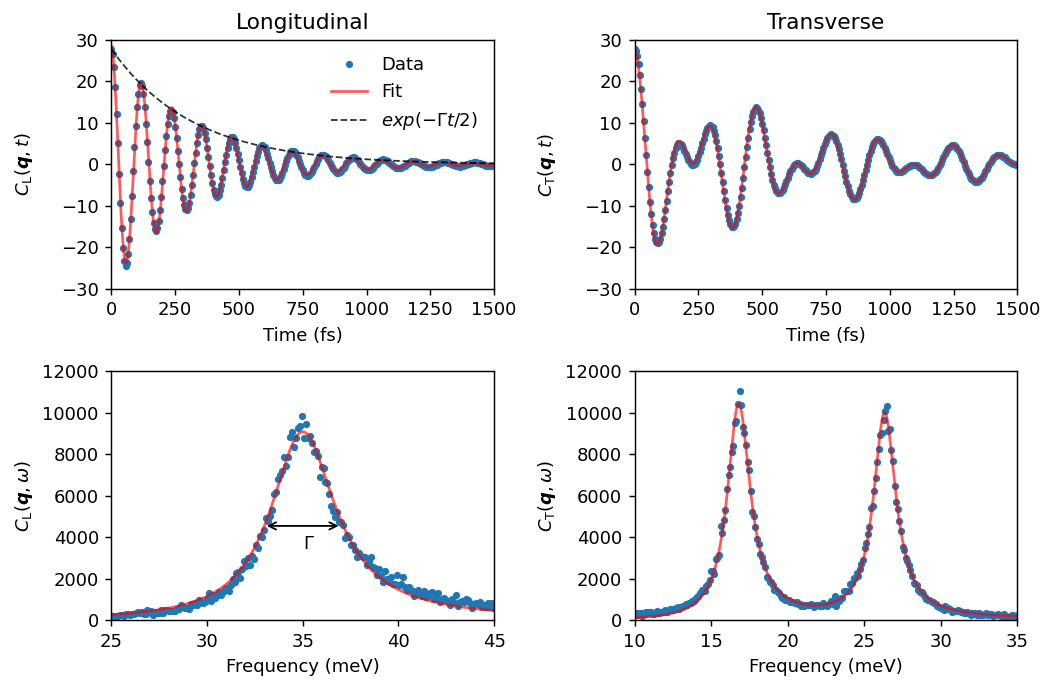

In [5]:
# plot params
t_lim = [0, 1500]
w_lim1 = [25, 45]
w_lim2 = [10, 35]

y_lim1 = [-30, 30]
y_lim2 = [0, 12000]
alpha = 0.65


# plot setup
fig = plt.figure(figsize=(8.2, 5.4), dpi=130)
gs = plt.GridSpec(2, 2)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])


# plotting time domain
ax1.plot(t, Clqt, '.', label='Data')
ax1.plot(t_lin, Clqt_fit, '-r', alpha=alpha, label='Fit')
ax1.plot(t_lin, Clqt[0] * np.exp(-t_lin * params_L[1]/2), '--k', alpha=0.8, lw=1.0, label=r'$exp(-\Gamma t /2)$')

ax1.set_xlabel('Time (fs)')
ax1.set_ylabel(r'$C_\text{L}(\boldsymbol{q}, t)$')
ax1.legend(loc=1, frameon=False)
ax1.set_title('Longitudinal')

ax2.plot(t, Ctqt, '.')
ax2.plot(t_lin, Ctqt_fit, '-r', alpha=alpha)
ax2.set_xlabel('Time (fs)')
ax2.set_ylabel(r'$C_\text{T}(\boldsymbol{q}, t)$')
ax2.set_title('Transverse')

for ax in [ax1, ax2]:
    ax.set_xlim(t_lim)
    ax.set_ylim(y_lim1)

# plotting frequency domain
ax3.plot(w * radians_per_fs_to_meV, Clqw, '.')
ax3.plot(w_lin * radians_per_fs_to_meV, Clqw_fit, '-r', alpha=alpha)

ax3.set_xlabel('Frequency (meV)')
ax3.set_ylabel(r'$C_\text{L}(\boldsymbol{q}, \omega)$')
ax3.set_xlim(w_lim1)
ax3.set_ylim(y_lim2)
ax3.annotate('', xy=(w0_L - gamma_L/2 , Clqw_fit.max() / 2.0), xytext=(w0_L + gamma_L/2, Clqw_fit.max() / 2.0), arrowprops=dict(arrowstyle='<->'))
ax3.text(w0_L, 0.75*Clqw_fit.max()/2, r'$\Gamma$')


ax4.plot(w * radians_per_fs_to_meV, Ctqw, '.')
ax4.plot(w_lin * radians_per_fs_to_meV, Ctqw_fit, '-r', alpha=alpha)

ax4.set_xlabel('Frequency (meV)')
ax4.set_ylabel(r'$C_\text{T}(\boldsymbol{q}, \omega)$')
ax4.set_xlim(w_lim2)
ax4.set_ylim(y_lim2)

fig.align_ylabels()
fig.tight_layout()

Note that, while the fits are carried out in the time domain, the corresponding DHO spectra match the data well in the frequency domain too. Generally, it is a good idea to plot the resulting fit in both the time and frequency domain, regardless of where the fit was performed, as a check of the procedure. In a simple system like this, is should not matter in which domain the fit is performed, but it might be easier to obtain a converged fit in one of the domains when more complex systems are considered.

## Cubic BaZrO3
Additionally, we will consider a more anharmonic system, the cubic phase of BaZrO3 (BZO), with  $S(\boldsymbol{q}, \omega)$ data from [this paper](https://doi.org/10.1021/acs.chemmater.3c02548).
We will analyze the low-frequency octahedral tilt phonon mode at the R-point ($\boldsymbol{q}=[1.5, 0.5, 0.5]$), at T = 300 K for three different pressure (0 GPa, 8 GPa, and 15.6 GPa).
Note that this phonon mode is related to the phase transition between the cubic and tetragonal phases which occurs at around 16 GPa.
The sample objects only contains $S(\boldsymbol{q}, \omega)$ for this specific q-point.


Note that for overdamped modes the DHO is better represented using two timescales $\tau_L$ and $\tau_S$ instead of $\omega_0$ and $\Gamma$. These are defined as
\begin{equation*}
\tau_\text{S,L} = \frac{\tau}{1 \pm \sqrt{1-(\omega_0\tau)^2}},
\end{equation*}
where $\tau=2/\Gamma$.

In [6]:
from dynasor.tools.damped_harmonic_oscillator import psd_position_dho


# read data
P_vals =  [0.0, 8.0, 15.6]
data_dict = dict()
for P in P_vals:
    fname = f'BaZrO3_sample_T300_P{P:.1f}.npz'
    sample = read_sample_from_npz(fname)
    data_dict[P] = radians_per_fs_to_meV * sample.omega, sample.Sqw[0]

Next, we visualize the three different spectra.

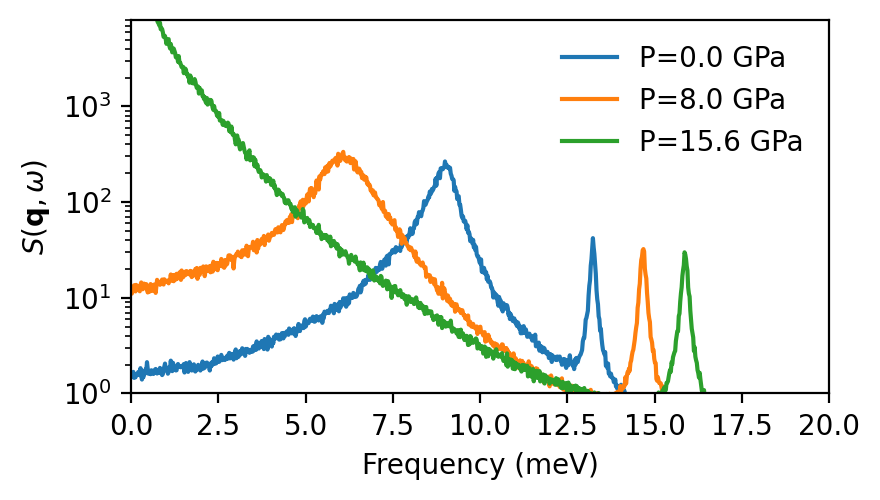

In [7]:
# figure setup
xlim = [0, 20]
ylim = [1, 8000]
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.6), dpi=200)


for P, (w, Sqw) in data_dict.items():
    ax.plot(w, Sqw, '-', label=f'P={P} GPa')

ax.legend(loc=1, frameon=False)
ax.set_xlabel('Frequency (meV)')
ax.set_ylabel(r'$S(\mathbf{q}, \omega)$')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yscale('log')
fig.tight_layout()

For P = 0 GPa we see two clear peaks at around 8 meV (octahedral tilt mode) and around 13 meV (acoustic Barium mode).
Additionally, there exist multiple modes above 20 meV, but here we focus on the low frequency mode.
For P = 15.6 GPa (close to the phase transition) one can clearly see that the tilt mode exhbits overdamped behaviour.

Next, we fit the corresponding spectra to DHOs, i.e., the fits are performed in the frequency domain. 

P= 0.0GPa : w0=8.99 meV, gamma=0.82 meV
P= 8.0GPa : w0=6.18 meV, gamma=1.48 meV
P=15.6GPa : w0=1.66 meV, gamma=6.17 meV


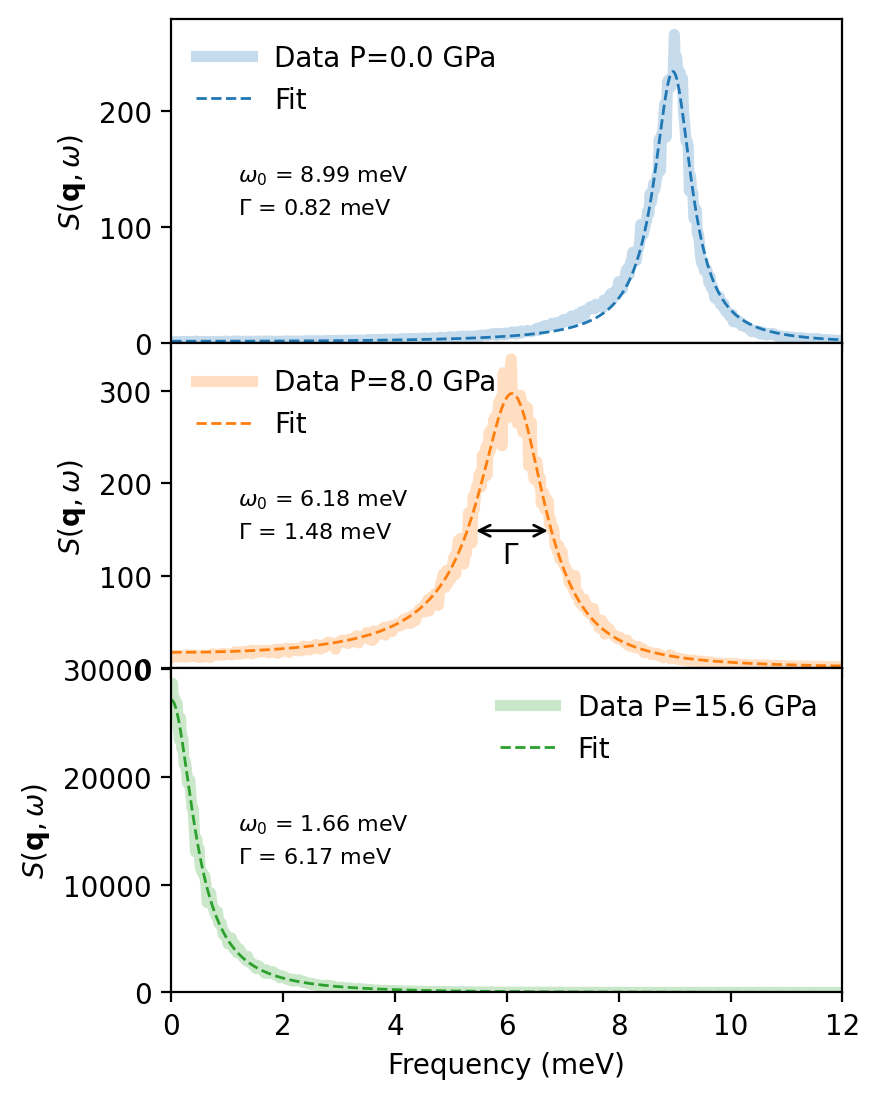

In [8]:
from dynasor.tools.damped_harmonic_oscillator import psd_position_dho

# figure setup
xlim = [0, 12]
ylim = [1, 25000]
fig, axes = plt.subplots(3, 1, figsize=(4.5, 5.6), dpi=200, sharex=True)



# parameters guess
p0 = [5.0, 2.0, 100]

colors_dict = dict()
colors_dict[0.0] = 'tab:blue'
colors_dict[8.0] = 'tab:orange'
colors_dict[15.6] = 'tab:green'

for ax, (P, (w, Sqw)) in zip(axes, data_dict.items()):

    
    # only use frequencies upto 12 meV
    mask = w <= xlim[1]
    
    # fit to DHO
    params, _ = curve_fit(psd_position_dho, w[mask], Sqw[mask], p0=p0)
    w0, gamma, A = params

    # print parameters
    print(f'P={P:4.1f}GPa : w0={w0:.2f} meV, gamma={gamma:.2f} meV')

    ax.text(0.1, 0.5, rf'$\omega_0$ = {w0:.2f} meV', transform=ax.transAxes, fontsize=8)
    ax.text(0.1, 0.4, rf'$\Gamma$ = {gamma:.2f} meV', transform=ax.transAxes, fontsize=8)


    # plot
    w_lin = np.linspace(*xlim, 100000)
    S_fit = psd_position_dho(w_lin, *params)
    ax.plot(w, Sqw, '-', lw=4.0, alpha=0.25, color=colors_dict[P], label=f'Data P={P} GPa')
    ax.plot(w_lin, S_fit, '--', lw=1.0, color=colors_dict[P], label=f'Fit')

    ax.set_xlim(xlim)
    ax.set_ylim(bottom=0.0)
    ax.legend(loc='best', frameon=False)
    ax.set_ylabel(r'$S(\mathbf{q}, \omega)$')
    
    # annotate roughly FWHM Gamma
    if P == 8.0:
        w_peak = np.sqrt(w0**2 - gamma**2 / 2.0)
        ax.annotate('', xy=(w_peak - gamma/2 , S_fit.max() / 2.0), xytext=(w_peak + gamma/2, S_fit.max() / 2.0), arrowprops=dict(arrowstyle='<->'))
        ax.text(w_peak-0.18, S_fit.max()/2 - 35, r'$\Gamma$')

axes[-1].set_xlabel('Frequency (meV)')
fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

For P = 15.6 GPa we obtain $\Gamma > 2 \omega_0$, meaning that the mode is overdamped.